In [66]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [68]:
!cp /content/drive/MyDrive/Kaggle_credentials/kaggle.json ~/.kaggle/kaggle.json

In [69]:
! chmod 600 ~/.kaggle/kaggle.json

In [70]:
# ! kaggle competitions download -c walmart-recruiting-store-sales-forecasting

In [71]:
# ! unzip /content/walmart-recruiting-store-sales-forecasting.zip
# ! unzip /content/train.csv.zip
# ! unzip /content/test.csv.zip
# ! unzip /content/features.csv.zip
# ! unzip /content/sampleSubmission.csv.zip

In [72]:
!pip install wandb -qU

In [73]:
import wandb
import random
import math

In [74]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [75]:
import pandas as pd
import numpy as np
import wandb
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pickle
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

# DATA EXPLORATION

In [76]:
# Change project name in all wandb.init() calls:
wandb.init(project="walmart-sales-forecasting", name="LightGBM_Data_Exploration", tags=["exploration", "lightgbm"])

print("=== WALMART SALES FORECASTING - DATA EXPLORATION ===\n")

# Load all datasets
print("Loading datasets...")
train = pd.read_csv("/content/train.csv")
features = pd.read_csv("/content/features.csv")
stores = pd.read_csv("/content/stores.csv")
test = pd.read_csv("/content/test.csv")
sample_submission = pd.read_csv("/content/sampleSubmission.csv")

print("Dataset shapes:")
print(f"Train: {train.shape}")
print(f"Features: {features.shape}")
print(f"Stores: {stores.shape}")
print(f"Test: {test.shape}")
print(f"Sample Submission: {sample_submission.shape}")

# Log basic dataset info
wandb.log({
    "train_rows": train.shape[0],
    "train_cols": train.shape[1],
    "features_rows": features.shape[0],
    "features_cols": features.shape[1],
    "stores_count": stores.shape[0],
    "test_rows": test.shape[0]
})

dataset_rows_final,▁
features_count,▁
new_features_created,▁
processed_features_count,▁
remaining_missing_values,▁
rows_removed,▁
target_max,▁
target_mean,▁
target_min,▁
target_std,▁
dataset_rows_final,421570


=== WALMART SALES FORECASTING - DATA EXPLORATION ===

Loading datasets...
Dataset shapes:
Train: (421570, 5)
Features: (8190, 12)
Stores: (45, 3)
Test: (115064, 4)
Sample Submission: (115064, 2)


In [77]:
# Explore individual datasets
print("\n=== TRAIN DATASET ===")
print("Columns:", train.columns.tolist())
print("\nFirst 5 rows:")
print(train.head())
print("\nBasic statistics:")
print(train.describe())
print(f"\nMissing values:\n{train.isnull().sum()}")

print("\n=== FEATURES DATASET ===")
print("Columns:", features.columns.tolist())
print(f"\nMissing values:\n{features.isnull().sum()}")
print("\nFeatures data sample:")
print(features.head())

print("\n=== STORES DATASET ===")
print("Columns:", stores.columns.tolist())
print(f"\nStore types: {stores['Type'].value_counts().to_dict()}")
print(f"Store sizes range: {stores['Size'].min()} - {stores['Size'].max()}")
print(stores.head())


=== TRAIN DATASET ===
Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']

First 5 rows:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Basic statistics:
               Store           Dept   Weekly_Sales
count  421570.000000  421570.000000  421570.000000
mean       22.200546      44.260317   15981.258123
std        12.785297      30.492054   22711.183519
min         1.000000       1.000000   -4988.940000
25%        11.000000      18.000000    2079.650000
50%        22.000000      37.000000    7612.030000
75%        33.000000      74.000000   20205.852500
max        45.000000      99.000000  693099.360000

Missing values:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
d

In [78]:
# Merge datasets for exploration
print("\n=== MERGING DATASETS ===")
data = train.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
data = data.merge(stores, on='Store', how='left')

print(f"Merged dataset shape: {data.shape}")
print(f"Missing values after merge:\n{data.isnull().sum()}")

# Convert date to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Basic time series analysis
print(f"\nDate range: {data['Date'].min()} to {data['Date'].max()}")
print(f"Unique stores: {data['Store'].nunique()}")
print(f"Unique departments: {data['Dept'].nunique()}")
print(f"Total weeks: {data['Date'].nunique()}")

# Log exploration metrics
wandb.log({
    "merged_shape_rows": data.shape[0],
    "merged_shape_cols": data.shape[1],
    "unique_stores": data['Store'].nunique(),
    "unique_departments": data['Dept'].nunique(),
    "unique_weeks": data['Date'].nunique(),
    "missing_values_total": data.isnull().sum().sum()
})


=== MERGING DATASETS ===
Merged dataset shape: (421570, 16)
Missing values after merge:
Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Unique stores: 45
Unique departments: 81
Total weeks: 143


# SOME VISUALS

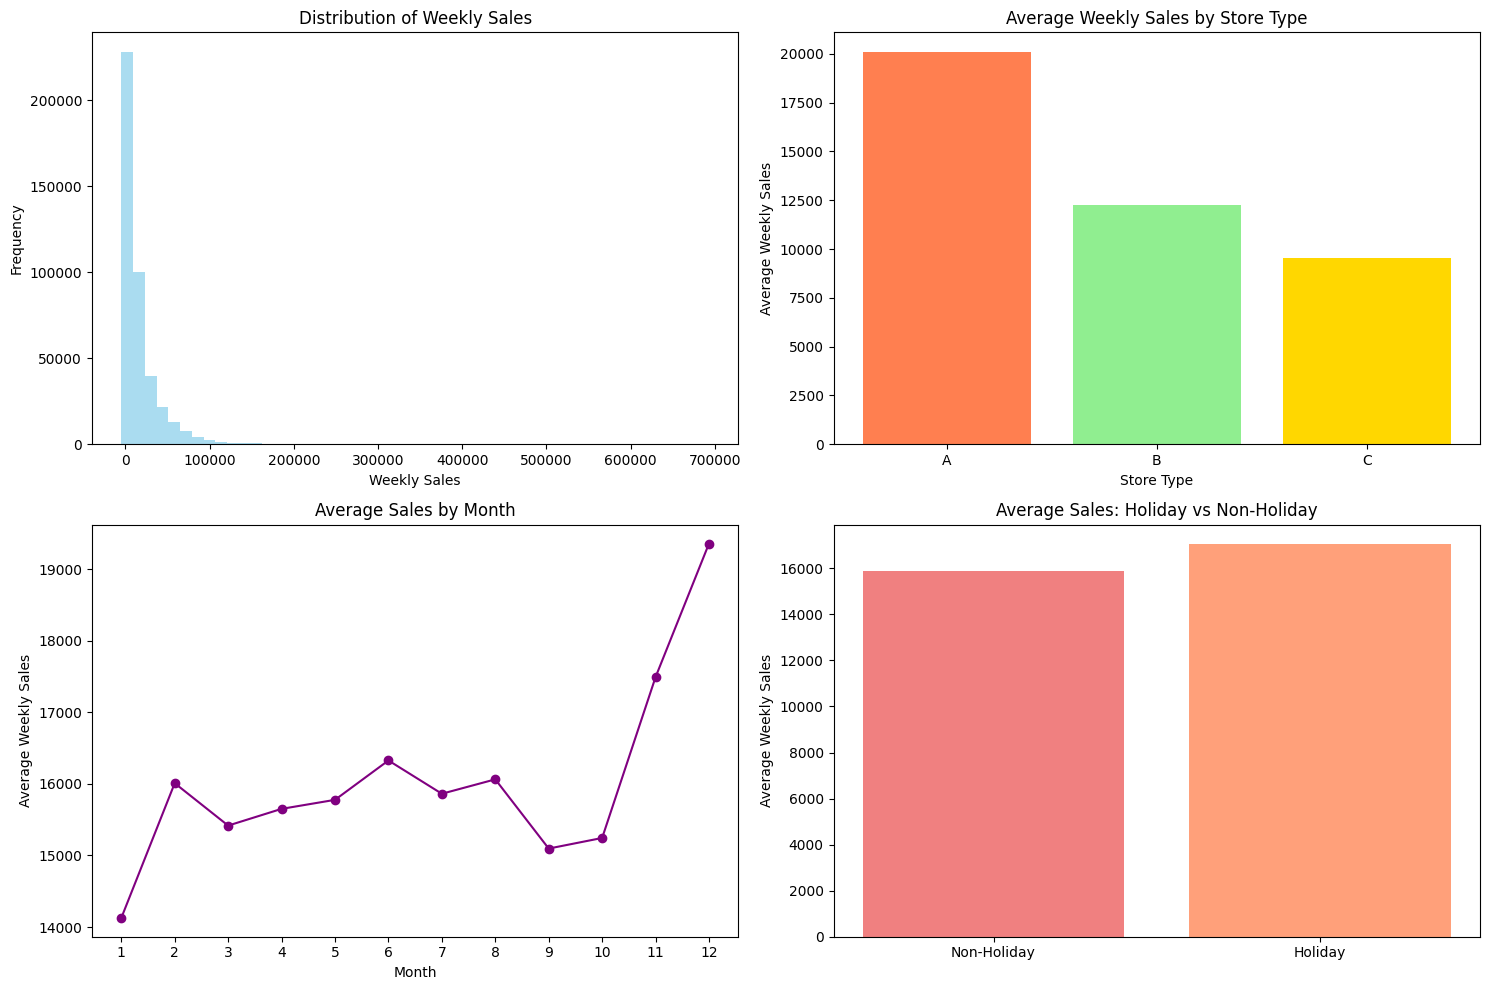

In [79]:
# Visualize sales distribution and patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sales distribution
axes[0, 0].hist(data['Weekly_Sales'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Distribution of Weekly Sales')
axes[0, 0].set_xlabel('Weekly Sales')
axes[0, 0].set_ylabel('Frequency')

# Sales by store type
store_sales = data.groupby('Type')['Weekly_Sales'].mean().reset_index()
axes[0, 1].bar(store_sales['Type'], store_sales['Weekly_Sales'], color=['coral', 'lightgreen', 'gold'])
axes[0, 1].set_title('Average Weekly Sales by Store Type')
axes[0, 1].set_xlabel('Store Type')
axes[0, 1].set_ylabel('Average Weekly Sales')

# Sales over time (monthly average)
data['Month'] = data['Date'].dt.month
monthly_sales = data.groupby('Month')['Weekly_Sales'].mean().reset_index()
axes[1, 0].plot(monthly_sales['Month'], monthly_sales['Weekly_Sales'], marker='o', color='purple')
axes[1, 0].set_title('Average Sales by Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Weekly Sales')
axes[1, 0].set_xticks(range(1, 13))

# Holiday vs Non-holiday sales
holiday_sales = data.groupby('IsHoliday')['Weekly_Sales'].mean()
axes[1, 1].bar(['Non-Holiday', 'Holiday'], holiday_sales.values, color=['lightcoral', 'lightsalmon'])
axes[1, 1].set_title('Average Sales: Holiday vs Non-Holiday')
axes[1, 1].set_ylabel('Average Weekly Sales')

plt.tight_layout()
plt.savefig('data_exploration.png', dpi=300, bbox_inches='tight')
wandb.log({"data_exploration": wandb.Image('data_exploration.png')})
plt.show()

# Correlation analysis


=== CORRELATION ANALYSIS ===


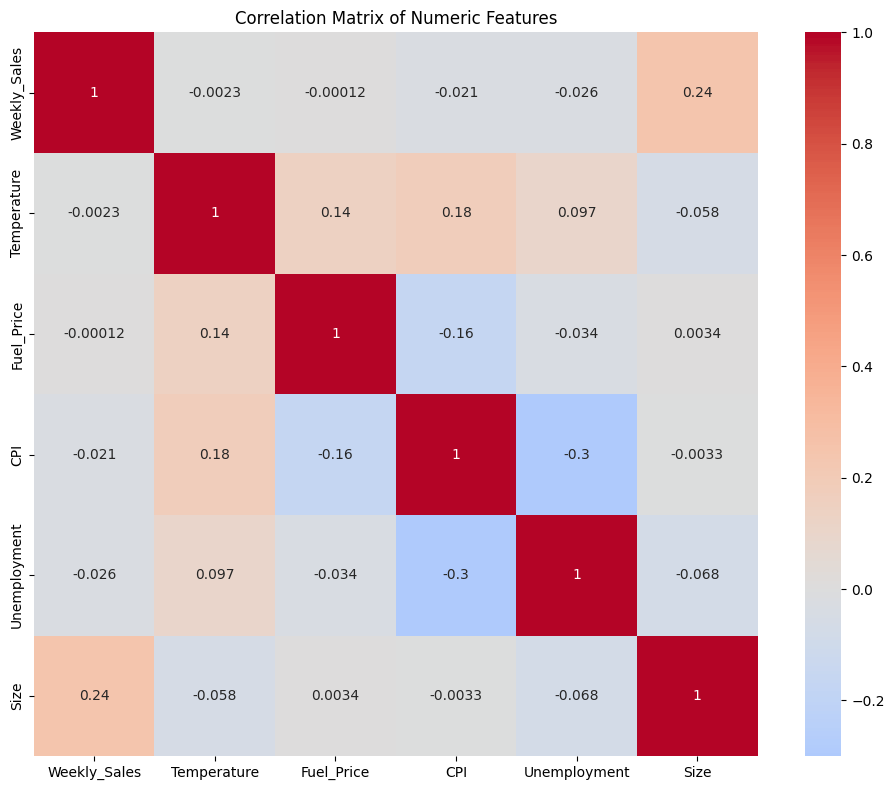

Key correlations with Weekly_Sales:
Size: 0.244
Unemployment: -0.026
CPI: -0.021
Temperature: -0.002
Fuel_Price: -0.000


features_cols,▁
features_rows,▁
merged_shape_cols,▁
merged_shape_rows,▁
missing_values_total,▁
stores_count,▁
test_rows,▁
train_cols,▁
train_rows,▁
unique_departments,▁
unique_stores,▁


In [80]:
# Correlation analysis
print("\n=== CORRELATION ANALYSIS ===")
numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
correlation_matrix = data[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
wandb.log({"correlation_matrix": wandb.Image('correlation_matrix.png')})
plt.show()

print("Key correlations with Weekly_Sales:")
sales_corr = correlation_matrix['Weekly_Sales'].sort_values(key=abs, ascending=False)
for feature, corr in sales_corr.items():
    if feature != 'Weekly_Sales':
        print(f"{feature}: {corr:.3f}")

wandb.finish()

# Pipeline Definition

In [81]:
# Initialize wandb for pipeline development
wandb.init(project="walmart-sales-forecasting", name="LightGBM_Pipeline_Development", tags=["pipeline", "lightbgm"])

print("=== DEVELOPING PREPROCESSING PIPELINE ===\n")

class WalmartDataPreprocessor(BaseEstimator, TransformerMixin):
    """
    Custom preprocessor for Walmart sales data that handles:
    - Missing value imputation
    - Date feature engineering
    - Categorical encoding
    - Time series feature creation
    - Interaction features
    """

    def __init__(self, create_lag_features=True, lag_periods=[1, 2, 4, 8],
                 rolling_windows=[4, 8, 12], create_interactions=True):
        self.create_lag_features = create_lag_features
        self.lag_periods = lag_periods
        self.rolling_windows = rolling_windows
        self.create_interactions = create_interactions
        self.label_encoders = {}
        self.feature_means = {}
        self.fitted = False

    def fit(self, X, y=None):
        """Fit the preprocessor on training data"""
        print("Fitting preprocessor...")

        X_copy = X.copy()

        # Store means for numeric features (for missing value imputation)
        numeric_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

        for col in numeric_cols:
            if col in X_copy.columns:
                self.feature_means[col] = X_copy[col].mean()

        # Fit label encoders for categorical variables
        categorical_cols = ['Type']
        for col in categorical_cols:
            if col in X_copy.columns:
                self.label_encoders[col] = LabelEncoder()
                # Handle unknown categories by adding 'Unknown'
                unique_values = X_copy[col].fillna('Unknown').unique()
                self.label_encoders[col].fit(unique_values)

        self.fitted = True
        print("Preprocessor fitted successfully!")
        return self

    def transform(self, X):
        """Transform the data using fitted parameters"""
        if not self.fitted:
            raise ValueError("Preprocessor must be fitted before transform!")

        X_processed = X.copy()
        print(f"Transforming data with shape: {X_processed.shape}")

        # 1. Date feature engineering
        X_processed['Date'] = pd.to_datetime(X_processed['Date'])
        X_processed['Year'] = X_processed['Date'].dt.year
        X_processed['Month'] = X_processed['Date'].dt.month
        X_processed['Week'] = X_processed['Date'].dt.isocalendar().week
        X_processed['DayOfYear'] = X_processed['Date'].dt.dayofyear
        X_processed['Quarter'] = X_processed['Date'].dt.quarter
        X_processed['WeekOfMonth'] = X_processed['Date'].dt.day // 7 + 1

        # 2. Cyclical features (important for time series)
        X_processed['Month_sin'] = np.sin(2 * np.pi * X_processed['Month'] / 12)
        X_processed['Month_cos'] = np.cos(2 * np.pi * X_processed['Month'] / 12)
        X_processed['Week_sin'] = np.sin(2 * np.pi * X_processed['Week'] / 52)
        X_processed['Week_cos'] = np.cos(2 * np.pi * X_processed['Week'] / 52)
        X_processed['Quarter_sin'] = np.sin(2 * np.pi * X_processed['Quarter'] / 4)
        X_processed['Quarter_cos'] = np.cos(2 * np.pi * X_processed['Quarter'] / 4)

        # 3. Missing value imputation
        numeric_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

        for col in numeric_cols:
            if col in X_processed.columns:
                mean_val = self.feature_means.get(col, 0)
                X_processed[col] = X_processed[col].fillna(mean_val)

        # 4. Categorical encoding
        for col, encoder in self.label_encoders.items():
            if col in X_processed.columns:
                # Handle unseen categories
                X_processed[col] = X_processed[col].fillna('Unknown')
                # Transform, handling unknown values
                known_categories = encoder.classes_
                X_processed[col] = X_processed[col].apply(
                    lambda x: x if x in known_categories else 'Unknown'
                )
                X_processed[col] = encoder.transform(X_processed[col])

        # 5. Interaction features
        if self.create_interactions:
            # Temperature-Holiday interaction
            if 'Temperature' in X_processed.columns and 'IsHoliday' in X_processed.columns:
                X_processed['Temp_Holiday_Interaction'] = X_processed['Temperature'] * X_processed['IsHoliday']

            # Store size interactions
            if 'Size' in X_processed.columns:
                if 'CPI' in X_processed.columns:
                    X_processed['Size_CPI_Interaction'] = X_processed['Size'] * X_processed['CPI']
                if 'Unemployment' in X_processed.columns:
                    X_processed['Size_Unemployment_Interaction'] = X_processed['Size'] * X_processed['Unemployment']

            # Fuel price interactions
            if 'Fuel_Price' in X_processed.columns and 'IsHoliday' in X_processed.columns:
                X_processed['FuelPrice_Holiday_Interaction'] = X_processed['Fuel_Price'] * X_processed['IsHoliday']

        # 6. Create markdown features
        markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
        existing_markdowns = [col for col in markdown_cols if col in X_processed.columns]

        if existing_markdowns:
            # Total markdowns
            X_processed['Total_MarkDown'] = X_processed[existing_markdowns].sum(axis=1)
            # Number of active markdowns
            X_processed['Active_MarkDowns'] = (X_processed[existing_markdowns] > 0).sum(axis=1)
            # Maximum markdown
            X_processed['Max_MarkDown'] = X_processed[existing_markdowns].max(axis=1)

        # 7. Boolean feature engineering
        X_processed['IsHoliday_int'] = X_processed['IsHoliday'].astype(int)

        # Remove original date column
        if 'Date' in X_processed.columns:
            X_processed = X_processed.drop('Date', axis=1)

        # Ensure all features are numeric
        for col in X_processed.columns:
            if X_processed[col].dtype == 'object':
                print(f"Warning: Column {col} is still object type")

        print(f"Processed data shape: {X_processed.shape}")
        return X_processed

# Test the preprocessor
print("Testing preprocessor with sample data...")

# Use a subset of data for testing
sample_data = data.head(1000).copy()
X_sample = sample_data.drop('Weekly_Sales', axis=1)
y_sample = sample_data['Weekly_Sales']

# Initialize and fit preprocessor
preprocessor = WalmartDataPreprocessor()
preprocessor.fit(X_sample)

# Transform data
X_transformed = preprocessor.transform(X_sample)

print(f"Original features: {X_sample.shape[1]}")
print(f"Transformed features: {X_transformed.shape[1]}")
print(f"New feature names: {list(X_transformed.columns)}")

# Log preprocessing results
wandb.log({
    "original_features": X_sample.shape[1],
    "transformed_features": X_transformed.shape[1],
    "feature_engineering_ratio": X_transformed.shape[1] / X_sample.shape[1]
})

print("\nPreprocessor created successfully!")
wandb.finish()

=== DEVELOPING PREPROCESSING PIPELINE ===

Testing preprocessor with sample data...
Fitting preprocessor...
Preprocessor fitted successfully!
Transforming data with shape: (1000, 16)
Processed data shape: (1000, 34)
Original features: 16
Transformed features: 34
New feature names: ['Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Month', 'Year', 'Week', 'DayOfYear', 'Quarter', 'WeekOfMonth', 'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos', 'Quarter_sin', 'Quarter_cos', 'Temp_Holiday_Interaction', 'Size_CPI_Interaction', 'Size_Unemployment_Interaction', 'FuelPrice_Holiday_Interaction', 'Total_MarkDown', 'Active_MarkDowns', 'Max_MarkDown', 'IsHoliday_int']

Preprocessor created successfully!


feature_engineering_ratio,▁
original_features,▁
transformed_features,▁
feature_engineering_ratio,2.125
original_features,16
transformed_features,34


# DATA PREPROCESSING AND INITIAL TRAINING

In [82]:
# Initialize wandb for preprocessing and training
wandb.init(project="walmart-sales-forecasting", name="LightGBM_Preprocessing_Training", tags=["preprocessing", "training", "lightbgm"])

print("=== DATA PREPROCESSING AND INITIAL TRAINING ===\n")

# Load and prepare full dataset
print("Loading and preparing full dataset...")
data = train.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
data = data.merge(stores, on='Store', how='left')

print(f"Full dataset shape: {data.shape}")

# Remove rows with missing target
initial_rows = data.shape[0]
data = data.dropna(subset=['Weekly_Sales'])
final_rows = data.shape[0]

print(f"Removed {initial_rows - final_rows} rows with missing target")
print(f"Final dataset shape: {data.shape}")

# Sort by store, department, and date for time series
data = data.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)

# Prepare features and target
X = data.drop('Weekly_Sales', axis=1)
y = data['Weekly_Sales']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target statistics:")
print(f"  Mean: {y.mean():.2f}")
print(f"  Std: {y.std():.2f}")
print(f"  Min: {y.min():.2f}")
print(f"  Max: {y.max():.2f}")

# Log data statistics
wandb.log({
    "dataset_rows_final": final_rows,
    "features_count": X.shape[1],
    "target_mean": y.mean(),
    "target_std": y.std(),
    "target_min": y.min(),
    "target_max": y.max(),
    "rows_removed": initial_rows - final_rows
})

=== DATA PREPROCESSING AND INITIAL TRAINING ===

Loading and preparing full dataset...
Full dataset shape: (421570, 16)
Removed 0 rows with missing target
Final dataset shape: (421570, 16)
Features shape: (421570, 15)
Target shape: (421570,)
Target statistics:
  Mean: 15981.26
  Std: 22711.18
  Min: -4988.94
  Max: 693099.36


# Preprocessing


In [83]:
# Create and fit preprocessor
print("\nFitting preprocessor on full dataset...")
preprocessor = WalmartDataPreprocessor(
    create_lag_features=True,
    lag_periods=[1, 2, 4, 8],
    rolling_windows=[4, 8, 12],
    create_interactions=True
)

# Fit preprocessor
preprocessor.fit(X)

# Transform features
print("Transforming features...")
X_processed = preprocessor.transform(X)

print(f"Processed features shape: {X_processed.shape}")
print(f"Feature engineering created {X_processed.shape[1] - X.shape[1]} new features")

# Check for any remaining missing values
missing_counts = X_processed.isnull().sum()
if missing_counts.sum() > 0:
    print(f"Warning: Still have missing values:")
    print(missing_counts[missing_counts > 0])
else:
    print("✓ No missing values in processed data")

# Log preprocessing results
wandb.log({
    "processed_features_count": X_processed.shape[1],
    "new_features_created": X_processed.shape[1] - X.shape[1],
    "remaining_missing_values": missing_counts.sum()
})


Fitting preprocessor on full dataset...
Fitting preprocessor...
Preprocessor fitted successfully!
Transforming features...
Transforming data with shape: (421570, 15)
Processed data shape: (421570, 34)
Processed features shape: (421570, 34)
Feature engineering created 19 new features
✓ No missing values in processed data


#  INITIAL MODEL TRAINING

In [84]:
# Initial model training with default parameters
print("\n=== INITIAL MODEL TRAINING ===")

# Simple train-test split for initial testing (last 20% as test)
split_point = int(0.8 * len(X_processed))
X_train_init = X_processed.iloc[:split_point]
X_test_init = X_processed.iloc[split_point:]
y_train_init = y.iloc[:split_point]
y_test_init = y.iloc[split_point:]

print(f"Initial train set: {X_train_init.shape}")
print(f"Initial test set: {X_test_init.shape}")

# Replace initial_params with:
initial_params = {
    'n_estimators': 500,                   # Higher default
    'max_depth': 7,
    'learning_rate': 0.04,                 # Slightly lower
    'subsample': 0.85,
    'feature_fraction': 0.85,              # Correct LightGBM parameter name
    'bagging_freq': 1,                     # Enable bagging (important!)
    'reg_alpha': 0.1,                      # L1 regularization
    'reg_lambda': 1.0,                     # L2 regularization
    'min_child_samples': 20,               # LightGBM equivalent of min_child_weight
    'min_split_gain': 0.0,                 # Minimum gain to make a split
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',               # Gradient boosting
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

print("Training initial LightBGM model...")
initial_model = lgb.LGBMRegressor(**initial_params)
initial_model.fit(X_train_init, y_train_init)

# Make predictions
y_pred_train = initial_model.predict(X_train_init)
y_pred_test = initial_model.predict(X_test_init)

# Calculate metrics
train_mae = mean_absolute_error(y_train_init, y_pred_train)
test_mae = mean_absolute_error(y_test_init, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train_init, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test_init, y_pred_test))

print(f"\nInitial Model Results:")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

# Log initial results
wandb.log({
    "initial_train_mae": train_mae,
    "initial_test_mae": test_mae,
    "initial_train_rmse": train_rmse,
    "initial_test_rmse": test_rmse,
    "initial_params": initial_params
})

# Feature importance from initial model
feature_importance = initial_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_processed.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print(f"\nTop 10 Most Important Features:")
for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
    print(f"{i+1}. {row['Feature']}: {row['Importance']:.4f}")

wandb.finish()


=== INITIAL MODEL TRAINING ===
Initial train set: (337256, 34)
Initial test set: (84314, 34)
Training initial LightBGM model...

Initial Model Results:
Train MAE: 3590.49
Test MAE: 5009.77
Train RMSE: 6004.97
Test RMSE: 8662.12

Top 10 Most Important Features:
1. Dept: 6269.0000
2. Size: 1634.0000
3. Store: 1617.0000
4. Size_CPI_Interaction: 833.0000
5. CPI: 656.0000
6. Week: 610.0000
7. DayOfYear: 447.0000
8. Size_Unemployment_Interaction: 429.0000
9. Unemployment: 400.0000
10. Temperature: 297.0000


dataset_rows_final,▁
features_count,▁
initial_test_mae,▁
initial_test_rmse,▁
initial_train_mae,▁
initial_train_rmse,▁
new_features_created,▁
processed_features_count,▁
remaining_missing_values,▁
rows_removed,▁
target_max,▁


In [85]:
# Initialize wandb for cross-validation and tuning
wandb.init(project="walmart-sales-forecasting", name="LightGBM_CrossValidation_Tuning", tags=["cv", "tuning", "lightbgm"])

print("=== CROSS-VALIDATION AND HYPERPARAMETER TUNING ===\n")

# Time series cross-validation setup
print("Setting up Time Series Cross-Validation...")
tscv = TimeSeriesSplit(n_splits=5, test_size=12)  # 12 weeks test size

print(f"Cross-validation setup:")
print(f"  Number of splits: 5")
print(f"  Test size: 12 weeks")

param_grid = {
    'n_estimators': [400, 600],           # Higher for better performance
    'max_depth': [6, 8],                  # Good range for LightGBM
    'learning_rate': [0.03, 0.05],        # Lower rates with more estimators
    'reg_lambda': [0.5, 1.5],             # Slightly wider regularization range
    'subsample': [0.8, 0.9],              # Add some variation
    'feature_fraction': [0.8],             # Keep stable
}

print(f"\nHyperparameter search space:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal combinations to test: {total_combinations}")

# Cross-validation function
def evaluate_params(params, X, y, cv_splits, verbose=True):
    """Evaluate parameters using time series cross-validation"""
    cv_scores = []

    for fold, (train_idx, val_idx) in enumerate(cv_splits.split(X)):
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]

        # Train model
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train_fold, y_train_fold)

        # Predict
        y_pred = model.predict(X_val_fold)

        # Calculate MAE
        mae = mean_absolute_error(y_val_fold, y_pred)
        cv_scores.append(mae)

        if verbose:
            print(f"    Fold {fold + 1}: MAE = {mae:.2f}")

    return cv_scores

# Hyperparameter tuning
print("\nStarting hyperparameter tuning...")
best_score = float('inf')
best_params = None
all_results = []

iteration = 0
for n_est in param_grid['n_estimators']:
    for max_d in param_grid['max_depth']:
        for lr in param_grid['learning_rate']:
            for subs in param_grid['subsample']:
                for feat_frac in param_grid['feature_fraction']:
                    iteration += 1

                    params = {
                        'n_estimators': n_est,
                        'max_depth': max_d,
                        'learning_rate': lr,
                        'subsample': subs,
                        'feature_fraction': feat_frac,  # Changed from colsample_bytree
                        'objective': 'regression',      # Changed from 'reg:squarederror'
                        'metric': 'mae',               # Added metric
                        'random_state': 42,
                        'n_jobs': -1,
                        'verbose': -1
                    }

                    print(f"\n[{iteration}/{total_combinations}] Testing parameters:")
                    print(f"  n_estimators={n_est}, max_depth={max_d}, lr={lr}, subsample={subs}, feat_frac={feat_frac}")

                    # Evaluate with cross-validation
                    cv_scores = evaluate_params(params, X_processed, y, tscv, verbose=False)

                    avg_score = np.mean(cv_scores)
                    std_score = np.std(cv_scores)

                    print(f"  CV Score: {avg_score:.3f} (+/- {std_score:.3f})")

                    # Log to wandb
                    wandb.log({
                        **params,
                        'cv_mae_mean': avg_score,
                        'cv_mae_std': std_score,
                        'cv_mae_min': min(cv_scores),
                        'cv_mae_max': max(cv_scores),
                        'iteration': iteration
                    })

                    # Store results
                    result = {
                        'params': params.copy(),
                        'cv_mean': avg_score,
                        'cv_std': std_score,
                        'cv_scores': cv_scores
                    }
                    all_results.append(result)

                    # Update best parameters
                    if avg_score < best_score:
                        best_score = avg_score
                        best_params = params.copy()
                        print(f"  *** NEW BEST SCORE: {best_score:.3f} ***")

print(f"\n=== HYPERPARAMETER TUNING COMPLETED ===")
print(f"Best CV Score: {best_score:.3f}")
print(f"Best Parameters: {best_params}")

# Log best results
wandb.log({
    'best_cv_mae': best_score,
    'best_params': best_params,
    'total_combinations_tested': total_combinations
})

# Analysis of results
results_df = pd.DataFrame([
    {**r['params'], 'cv_mean': r['cv_mean'], 'cv_std': r['cv_std']}
    for r in all_results
])

print(f"\nTop 5 parameter combinations:")
top_5 = results_df.nsmallest(5, 'cv_mean')[['n_estimators', 'max_depth', 'learning_rate', 'cv_mean', 'cv_std']]
print(top_5)

wandb.finish()

=== CROSS-VALIDATION AND HYPERPARAMETER TUNING ===

Setting up Time Series Cross-Validation...
Cross-validation setup:
  Number of splits: 5
  Test size: 12 weeks

Hyperparameter search space:
  n_estimators: [400, 600]
  max_depth: [6, 8]
  learning_rate: [0.03, 0.05]
  reg_lambda: [0.5, 1.5]
  subsample: [0.8, 0.9]
  feature_fraction: [0.8]

Total combinations to test: 32

Starting hyperparameter tuning...

[1/32] Testing parameters:
  n_estimators=400, max_depth=6, lr=0.03, subsample=0.8, feat_frac=0.8
  CV Score: 1505.322 (+/- 543.411)
  *** NEW BEST SCORE: 1505.322 ***

[2/32] Testing parameters:
  n_estimators=400, max_depth=6, lr=0.03, subsample=0.9, feat_frac=0.8
  CV Score: 1505.322 (+/- 543.411)

[3/32] Testing parameters:
  n_estimators=400, max_depth=6, lr=0.05, subsample=0.8, feat_frac=0.8
  CV Score: 1135.169 (+/- 363.929)
  *** NEW BEST SCORE: 1135.169 ***

[4/32] Testing parameters:
  n_estimators=400, max_depth=6, lr=0.05, subsample=0.9, feat_frac=0.8
  CV Score: 1135.

best_cv_mae,▁
cv_mae_max,██▄▄▄▄▁▁▅▅▃▃▅▅▂▂
cv_mae_mean,██▃▃▆▆▁▁▅▅▁▁▃▃▁▁
cv_mae_min,▄▄▅▅██▅▅▂▂▁▁▄▄▄▄
cv_mae_std,██▄▄▂▂▁▁▇▇▇▇▆▆▂▂
feature_fraction,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
learning_rate,▁▁██▁▁██▁▁██▁▁██
max_depth,▁▁▁▁████▁▁▁▁████
n_estimators,▁▁▁▁▁▁▁▁████████
n_jobs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


# FINAL MODEL TRAINING AND ANALYSIS

In [86]:
# Initialize wandb for final training
wandb.init(project="walmart-sales-forecasting", name="LightGBM_Final_Training", tags=["final", "training", "lightbgm", "production"])

print("=== FINAL MODEL TRAINING AND ANALYSIS ===\n")

# Load best parameters (use best found or defaults if none)
final_params = best_params if 'best_params' in locals() and best_params else {
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'n_jobs': -1
}

print("Final model parameters:")
for param, value in final_params.items():
    print(f"  {param}: {value}")

# Log final parameters
wandb.log(final_params)

=== FINAL MODEL TRAINING AND ANALYSIS ===

Final model parameters:
  n_estimators: 600
  max_depth: 8
  learning_rate: 0.05
  subsample: 0.8
  feature_fraction: 0.8
  objective: regression
  metric: mae
  random_state: 42
  n_jobs: -1
  verbose: -1


# Final pipeline

In [87]:
# Create final pipeline
print("\nCreating final pipeline...")

final_preprocessor = WalmartDataPreprocessor(
    create_lag_features=True,
    lag_periods=[1, 2, 4, 8],
    rolling_windows=[4, 8, 12],
    create_interactions=True
)

final_model = lgb.LGBMRegressor(**final_params)

# Create pipeline
final_pipeline = Pipeline([
    ('preprocessor', final_preprocessor),
    ('model', final_model)
])

print("Pipeline created successfully!")


Creating final pipeline...
Pipeline created successfully!


# Final model training

In [88]:
# Train final model on full dataset
print("\nTraining final model on full dataset...")

# Prepare final dataset
X_final = data.drop('Weekly_Sales', axis=1)
y_final = data['Weekly_Sales']

print(f"Training on {len(X_final)} samples with {X_final.shape[1]} features")

# Fit pipeline
final_pipeline.fit(X_final, y_final)

print("Final model trained successfully!")

# Make predictions for evaluation
print("Making predictions on training data...")
y_pred_final = final_pipeline.predict(X_final)

# Calculate comprehensive metrics
train_mae = mean_absolute_error(y_final, y_pred_final)
train_rmse = np.sqrt(mean_squared_error(y_final, y_pred_final))
train_mape = np.mean(np.abs((y_final - y_pred_final) / y_final)) * 100

# Calculate R²
from sklearn.metrics import r2_score
train_r2 = r2_score(y_final, y_pred_final)

print(f"\n=== FINAL MODEL PERFORMANCE ===")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MAPE: {train_mape:.2f}%")
print(f"Training R²: {train_r2:.4f}")

# Log final metrics
wandb.log({
    'final_train_mae': train_mae,
    'final_train_rmse': train_rmse,
    'final_train_mape': train_mape,
    'final_train_r2': train_r2,
    'final_samples_count': len(X_final)
})


Training final model on full dataset...
Training on 421570 samples with 15 features
Fitting preprocessor...
Preprocessor fitted successfully!
Transforming data with shape: (421570, 15)
Processed data shape: (421570, 34)
Final model trained successfully!
Making predictions on training data...
Transforming data with shape: (421570, 15)
Processed data shape: (421570, 34)

=== FINAL MODEL PERFORMANCE ===
Training MAE: 3110.92
Training RMSE: 5303.69
Training MAPE: inf%
Training R²: 0.9455


# Analysis


=== FEATURE IMPORTANCE ANALYSIS ===
Transforming data with shape: (1, 15)
Processed data shape: (1, 34)
Top 20 Most Important Features:
 1. Dept                      | 6365.0000 (35.4%)
 2. Store                     | 2174.0000 (12.1%)
 3. Size                      | 2015.0000 (11.2%)
 4. Size_CPI_Interaction      | 1218.0000 (6.8%)
 5. CPI                       | 854.0000 (4.7%)
 6. Size_Unemployment_Interaction | 689.0000 (3.8%)
 7. Week                      | 660.0000 (3.7%)
 8. Unemployment              | 592.0000 (3.3%)
 9. DayOfYear                 | 497.0000 (2.8%)
10. Temperature               | 388.0000 (2.2%)
11. Type                      | 334.0000 (1.9%)
12. Week_cos                  | 284.0000 (1.6%)
13. Fuel_Price                | 277.0000 (1.5%)
14. Week_sin                  | 230.0000 (1.3%)
15. WeekOfMonth               | 219.0000 (1.2%)
16. Month                     | 201.0000 (1.1%)
17. MarkDown3                 | 179.0000 (1.0%)
18. MarkDown5                 | 93.0

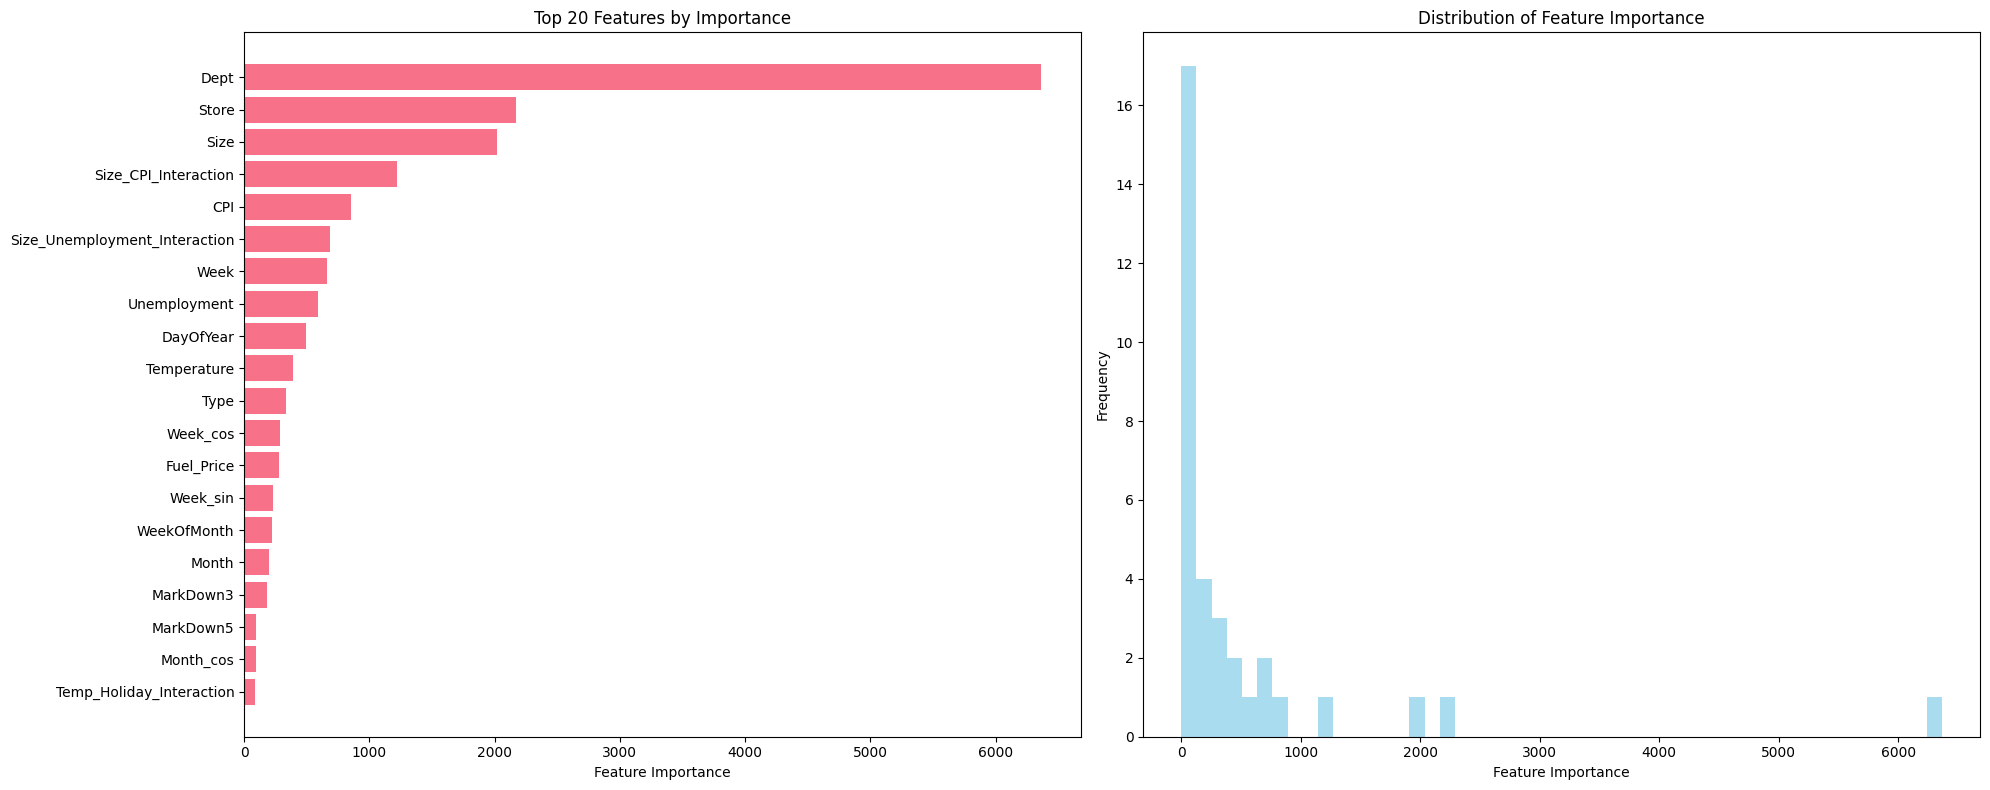

In [89]:
# Feature importance analysis
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

feature_importance = final_model.feature_importances_
processed_features = final_preprocessor.transform(X_final.head(1))
feature_names = processed_features.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance,
    'Importance_Pct': (feature_importance / feature_importance.sum()) * 100
}).sort_values('Importance', ascending=False)

print(f"Top 20 Most Important Features:")
for i, (_, row) in enumerate(importance_df.head(20).iterrows()):
    print(f"{i+1:2d}. {row['Feature']:<25} | {row['Importance']:.4f} ({row['Importance_Pct']:.1f}%)")

# Create feature importance visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Top 20 features
top_20 = importance_df.head(20)
ax1.barh(range(len(top_20)), top_20['Importance'])
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20['Feature'])
ax1.set_xlabel('Feature Importance')
ax1.set_title('Top 20 Features by Importance')
ax1.invert_yaxis()

# Feature importance distribution
ax2.hist(importance_df['Importance'], bins=50, alpha=0.7, color='skyblue')
ax2.set_xlabel('Feature Importance')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Feature Importance')

plt.tight_layout()
plt.savefig('final_feature_importance.png', dpi=300, bbox_inches='tight')
wandb.log({"final_feature_importance": wandb.Image('final_feature_importance.png')})
plt.show()

# Log top features
wandb.log({
    'top_10_features': top_20.head(10)['Feature'].tolist(),
    'top_20_features_table': wandb.Table(dataframe=top_20),
    'total_features': len(feature_names)
})

# MODEL PERFORMANCE VISUALIZATION


=== MODEL PERFORMANCE VISUALIZATION ===


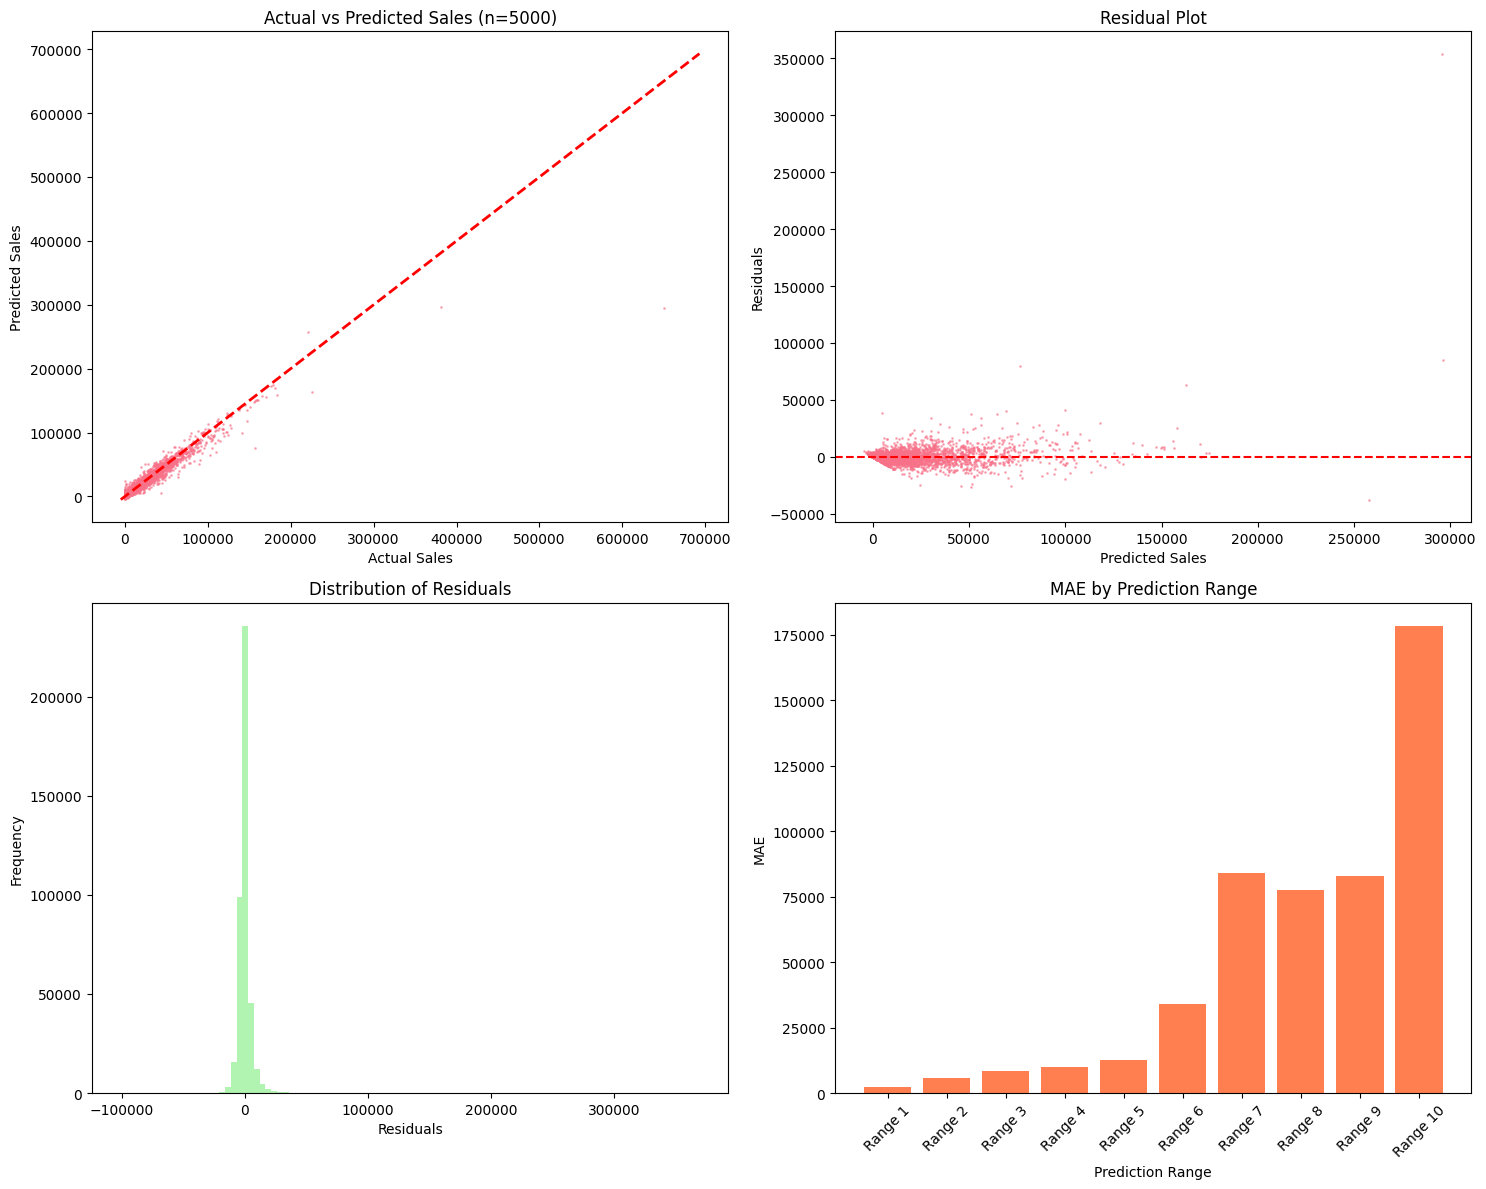


Residual Analysis:
Residual Mean: 0.60
Residual Std: 5303.70
Residual Skewness: 5.657
Residual Kurtosis: 213.823


In [90]:
# Model performance visualization
print("\n=== MODEL PERFORMANCE VISUALIZATION ===")

# Create performance plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted (sample)
sample_size = min(5000, len(y_final))
sample_indices = np.random.choice(len(y_final), size=sample_size, replace=False)
sample_actual = y_final.iloc[sample_indices]
sample_pred = y_pred_final[sample_indices]

axes[0, 0].scatter(sample_actual, sample_pred, alpha=0.5, s=1)
axes[0, 0].plot([y_final.min(), y_final.max()], [y_final.min(), y_final.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Sales')
axes[0, 0].set_ylabel('Predicted Sales')
axes[0, 0].set_title(f'Actual vs Predicted Sales (n={sample_size})')

# 2. Residuals
residuals = y_final - y_pred_final
axes[0, 1].scatter(y_pred_final[sample_indices], residuals.iloc[sample_indices], alpha=0.5, s=1)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Sales')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')

# 3. Residual distribution
axes[1, 0].hist(residuals, bins=100, alpha=0.7, color='lightgreen')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')

# 4. Performance by prediction range
pred_ranges = pd.cut(y_pred_final, bins=10, labels=False)
range_mae = []
range_labels = []
for i in range(10):
    mask = pred_ranges == i
    if mask.sum() > 0:
        range_mae.append(mean_absolute_error(y_final[mask], y_pred_final[mask]))
        range_labels.append(f'Range {i+1}')

axes[1, 1].bar(range(len(range_mae)), range_mae, color='coral')
axes[1, 1].set_xlabel('Prediction Range')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].set_title('MAE by Prediction Range')
axes[1, 1].set_xticks(range(len(range_labels)))
axes[1, 1].set_xticklabels(range_labels, rotation=45)

plt.tight_layout()
plt.savefig('final_model_performance.png', dpi=300, bbox_inches='tight')
wandb.log({"final_model_performance": wandb.Image('final_model_performance.png')})
plt.show()

# Residual statistics
print(f"\nResidual Analysis:")
print(f"Residual Mean: {residuals.mean():.2f}")
print(f"Residual Std: {residuals.std():.2f}")
print(f"Residual Skewness: {residuals.skew():.3f}")
print(f"Residual Kurtosis: {residuals.kurtosis():.3f}")

wandb.log({
    'residual_mean': residuals.mean(),
    'residual_std': residuals.std(),
    'residual_skewness': residuals.skew(),
    'residual_kurtosis': residuals.kurtosis()
})

# SAVING FINAL MODEL

In [91]:
# Save final model
print("\n=== SAVING FINAL MODEL ===")


# Fix MAPE calculation (handle zero values)
def safe_mape(y_true, y_pred):
    """Calculate MAPE while handling zero values"""
    mask = y_true != 0
    if mask.sum() == 0:
        return float('inf')
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

train_mape_fixed = safe_mape(y_final, y_pred_final)
print(f"Corrected Training MAPE: {train_mape_fixed:.2f}%")

# Save pipeline with cloudpickle (handles custom classes better)
try:
    import cloudpickle
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'cloudpickle'])
    import cloudpickle

# Change filename patterns:
pipeline_filename = f"lightgbm_pipeline_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl"

# Save with cloudpickle
with open(pipeline_filename, 'wb') as f:
    cloudpickle.dump(final_pipeline, f)

print(f"Pipeline saved as: {pipeline_filename}")

# Try to upload to wandb with error handling
try:
    # Create model artifact with fixed metadata
    model_artifact = wandb.Artifact(
        name="LightGBM_pipeline",
        type="model",
        description="Final LightBGM pipeline for Walmart sales forecasting",
        metadata={
            "train_mae": float(train_mae),
            "train_rmse": float(train_rmse),
            "train_mape": float(train_mape_fixed) if not np.isinf(train_mape_fixed) else 0.0,
            "train_r2": float(train_r2),
            "features_count": len(feature_names),
            "training_samples": len(X_final),
            "model_type": "LightBGM"
        }
    )

    # Add model file to artifact
    model_artifact.add_file(pipeline_filename)

    # Log artifact
    wandb.log_artifact(model_artifact)
    print("✓ Model artifact logged to wandb successfully!")

except Exception as e:
    print(f"⚠️ Error uploading to wandb: {e}")
    print("Model saved locally - you can manually upload later")

    # Log just the metrics without artifact
    wandb.log({
        'final_train_mae': train_mae,
        'final_train_rmse': train_rmse,
        'final_train_mape': train_mape_fixed if not np.isinf(train_mape_fixed) else 0.0,
        'final_train_r2': train_r2,
        'model_saved_locally': pipeline_filename
    })

# Final summary with corrected MAPE
print(f"\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"Model Type: LightGBM Regressor")  # Changed from XGBoost
print(f"Training Samples: {len(X_final):,}")
print(f"Features: {len(feature_names)}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MAPE: {train_mape_fixed:.2f}%")
print(f"Training R²: {train_r2:.4f}")
print(f"Pipeline saved as: {pipeline_filename}")
print("="*60)

wandb.finish()


=== SAVING FINAL MODEL ===
Corrected Training MAPE: 5935.38%
Pipeline saved as: lightgbm_pipeline_20250704_205747.pkl
✓ Model artifact logged to wandb successfully!

FINAL MODEL SUMMARY
Model Type: LightGBM Regressor
Training Samples: 421,570
Features: 34
Training MAE: 3110.92
Training RMSE: 5303.69
Training MAPE: 5935.38%
Training R²: 0.9455
Pipeline saved as: lightgbm_pipeline_20250704_205747.pkl


feature_fraction,▁
final_samples_count,▁
final_train_mae,▁
final_train_r2,▁
final_train_rmse,▁
learning_rate,▁
max_depth,▁
n_estimators,▁
n_jobs,▁
random_state,▁
residual_kurtosis,▁
